# Open American Standard Version (OASV)

**The OASV is an open-source update to the venerable 1901 American Standard Version (ASV)!**


The 1901 ASV is a classic English translation of the Bible. It is based on the Textus Receptus. It has high literal fidelity to the Koine Greek. And best of all, it is in the Public Domain, which means it is free to quote, reprint, copy and use for any purpose. Unfortunately, the language of the ASV is archaic, and nearly inaccessible to the modern reader.

The OASV is *nearly identical* to the ASV in every way, including word order, punctuation and capitalization. This ensures that the OASV has the same literal fidelity to the original Greek. However, the language of the ASV has been updated for modern readers, bringing this classic text to a new generation.


Importantly, the OASV is completely open-source. The full text is free to use, free to copy and free to print. Better yet, not only is the finished text freely available, but so is the entire methodology for its generation. I hope you gain something from the code presented here, but I hope even more that you benefit from reading, sharing and building upon this modern translation of the free and open Bible.

## Getting Started

First things first, we need to install and import various python libraries, establish our file structure, and set up our environment for generating, storing and validating the text of the OASV.

In [1]:
%pip install --upgrade openai
!pip install ebooklib
!apt-get install calibre

import subprocess
from openai import OpenAI
import os
import re
import time
import random
from google.colab import drive
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
from ebooklib import epub

## Set the API key and model name
OPENAI_API_KEY="INSERT_KEY_HERE"
MODEL="gpt-4o"
client = OpenAI(api_key=OPENAI_API_KEY)

## mount google Drive and Create OASV folder
drive.mount('/content/drive')
OASV_path = f"/content/drive/My Drive/OASV_JHV"
if not os.path.exists(OASV_path):
  os.makedirs(OASV_path)

## write the similarity score file
similarity_scores_path = f"{OASV_path}/similarity_scores"
if not os.path.exists(similarity_scores_path):
  with open(similarity_scores_path, "w") as f:
    f.write(f"verse, ASV, NIV, NASB\n")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.4/567.4 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.61.1
    Uninstalling openai-1.61.1:
      Successfully uninstalled openai-1.61.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.5/115.5 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ebooklib: filename=EbookLib-0.18-py3-none-any.whl size=38778 sha256=27da25ee70fc5e31741fdaa8cae8aec2521305c3ed9d3b58ef3894ee0c1ffebb
  Stored in directory: /root/.cache/pip/wheels/65/2b/63/68307c736d5a2fafeebe9df3e5eccacfe892204ce1fd31a03c
Successfully built ebooklib
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following package was automatically installed and is no longer required:
  libfuse2
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  avahi-daemon calibre-bin dictionaries-common dmidecode dosfstools eject fdisk 

## Defining the ChatGPT models

The heart of the OASV generation methodology is the chatGPT-4o Large Language Model (LLM). This model is incredibly powerful, and we use it here to surgically remove the archaic language from the original 1901 ASV text. We also use the LLM for quality control, both to ensure that the generated text includes all the verses of the original and to ensure that the verses themselves are true to the original ASV and not plagarisms of other modern translations.

In [2]:
def gen_OASV_Chapter(book, abb, chapter):
  # Use ChatGPT to build one chapter of the OASV Bible
  system_role = f'''Please modernize the ASV translation of the Bible book {book} according to the following strict guidelines:
                 Replace all archaic prepositions, adverbs, verbs, verb endings, and nouns in the provided ASV Bible text with their modern English equivalents, preserving the original word order and sentence structure as closely as possible.
                 Retain the exact wording and sentence structures of the ASV as closely as possible—only modernizing archaic words and awkward phrasings.
                    * Replace all archaic pronouns, tranistions and prepositions (thee, thou, ye, verily, hereof, thereof, thereunto, unto, etc).
                    * Replace all archaic nouns (householder, lading, bretheren, kindred, dayspring, salutation, ministration, tumult, variance, countenance, supplication, etc)
                    * Replace all archaic verbs (begat, proceedeth, beesech, dwelt, shalt, platted, etc).
                    * Modernize awkward word placement (then was Jesus led, will be given you, if therefore, afterward to be spoken, according as his work is, if it be, of a surety, who am old, etc).
                    * Modernize archaic negative constructions (knew her not, answered nothing, fear them not, etc).
                    * DO NOT alter any punctuation markings or capitalizations.
                    * DO NOT add ANY quotation markings. The ASV.does not use quotes, so please be true to the ASV and don't add any quotes.
                    * DO NOT replace the name 'Jehovah' in the ASV with 'LORD' or 'Yahweh' or any other name for God... stay true to the ASV translation.
                    * DO NOT alter the text based on other translations or introduce wording from other translations—only replace outdated language with modern equivalents while keeping the ASV's structure intact.
                    * Output each verse on its own line, with each verse marked in the following format: [book.chapter.verse], e.g., [{abb}.1.1].
                    * Output the first line of text exactly as follows: book chapter, e.g., {book} 1.
                 Please apply these rules strictly and consistently across all chapters!'''

  print(f"Processing {book} {chapter}... ", end="")
  completion = client.chat.completions.create(
    model=MODEL,
    messages=[
      {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
      {"role": "user", "content": f"{book} {chapter}"}  # <-- This is the user message for which the model will generate a response
    ]
  )
  chapter_text = completion.choices[0].message.content

  # Save the output and return
  file_path = f"{OASV_path}/_{book}"
  file_name = f"{book}_{chapter:03}"
  save_text_to_file(file_path, file_name, chapter_text)
  print(f"Saved file to {file_path}/{file_name}")
  return chapter_text


In [3]:
def get_Chapter_Length(book, chapter, retries=3):
  # Use ChatGPT to check one verse of the OASV Bible
  system_role = '''Return the number of verses in [Book] [Chapter] as an integer. DO NOT output any other text.
                For example:
                - Input: Matthew 6
                - Output: 34'''

  for attempt in range(retries):
    try:
      completion = client.chat.completions.create(
        model=MODEL,
        messages=[
          {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
          {"role": "user", "content": f"{book} {chapter}"}  # <-- This is the user message for which the model will generate a response
        ]
      )
      chapter_length = int(completion.choices[0].message.content)
      return chapter_length
    except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print("Retrying...")
            # Add a small delay before retrying
            time.sleep(2) # Import time module if not already present
        else:
            print("Max retries exceeded. Skipping this chapter.")
            raise Exception(f"Max retries exceeded. Skipping {book} {chapter}.")
            return None # Or handle the error as needed


In [29]:
def check_Verse_Quality(text, verbose=False):
  # Use ChatGPT to check one verse of the OASV Bible

  system_role = '''Compare the given Bible verse to the American Standard Version (ASV), New International Version (NIV), and New American Standard Bible (NASB).
                 Assign a similarity score between 0 and 100 for each translation based on wording and structure.
                 ** Output three integers separated by commas (e.g., 98,85,95).
                 ** The first integer represents the similarity score for the ASV.
                 ** The second integer represents the similarity score for the NIV.
                 ** The third integer represents the similarity score for the NASB.
                 ** If the provided text does not match the referenced verse, return 0,0,0.
                 ** If the provided text matches perfectly, return 100,100,100.
                 '''

  if verbose:
    system_role += "** Please also provide the text of ASV, NIV, and NASB for the verse, and explain the rationale for each similarity score."
  else:
    system_role += "** DO NOT add any extra text, only output the three integers separated by commas!!"
  completion = client.chat.completions.create(
    model=MODEL,
    messages=[
      {"role": "system", "content": system_role}, # <-- This is the system message that provides context to the model
      {"role": "user", "content": text}  # <-- This is the user message for which the model will generate a response
    ]
  )

  try:
    verse_id = text.split()[0]
    verse_score = completion.choices[0].message.content
  except:
    verse_id = "unk"
    verse_score = "0,0,0"

  print(f"{verse_score} -- {text}")
  with open(similarity_scores_path, "a") as f:
    f.write(f"{verse_id},{verse_score}\n")
  return verse_score


In [43]:
def save_text_to_file(folder_path, file_name, text_content):
    # Define the full file path
    file_path = f"{folder_path}/{file_name}"

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the text to the file
    with open(file_path, "w") as f:
        f.write(text_content)



def check_Chapter_length(book, abb, chapter, chapter_text):
    chapter_verses = [verse for verse in chapter_text.split('\n') if verse.startswith(f'[{abb}.')]

    # Check to ensure the whole Chapter was generated
    chapter_length = get_Chapter_Length(book, chapter)
    generated_length = len(chapter_verses)

    if generated_length < chapter_length:
      print(f"Warning: {book} {chapter} has {generated_length}/{chapter_length} verses")
      additional_text = gen_OASV_Chapter(book, f"{chapter}:{generated_length+1}")
      chapter_text += additional_text

    return chapter_text

def combine_chapters(book):
  book_text = ""
  directory = f"{OASV_path}/_{book}"
  for filename in os.listdir(directory):
    with open(f"{directory}/{filename}", "r") as f:
      chapter_text = f.read()
    book_text += f"{chapter_text}\n"

  # Save the text to the file
  with open(f"{OASV_path}/{book}", "w") as f:
    f.write(book_text)


def check_Chapter_Quality(chapter_text, num_verses_to_check):
  """
  Splits a string by carriage returns, randomly selects a specified number of lines,
  and processes each selected line using a placeholder function.

  Args:
    chapter_text: The input string to be split.
    num_verses_to_check: The number of lines to randomly select.
    placeholder_function: The function to apply to each selected line.
  """
  verses = chapter_text.split('\n')
  verses = [verse for verse in verses if verse.startswith('[')]

  if len(verses) < num_verses_to_check:
    print(f"Warning: Not enough verses to sample ({len(verses)} available, {num_verses_to_check} requested). Sampling all verses.")
    selected_verses = verses
  else:
    selected_verses = random.sample(verses, num_verses_to_check)

  for verse in selected_verses:
    quality = check_Verse_Quality(verse) # Call the check_OASV_Verse function with each selected verse
    if quality == "0,0,0":  # Check for the specific output
      raise Exception(f"Verse quality check failed for verse: {verse}")



In [ ]:
# prompt: randomly sample verses with check for population size

def randomly_sample_verses(chapter_text, num_verses_to_sample):
  """
  Randomly samples verses from a chapter text, checking for population size.

  Args:
    chapter_text: The text of the chapter.
    num_verses_to_sample: The number of verses to sample.

  Returns:
    A list of sampled verses.
  """
  verses = chapter_text.split('\n')
  verses = [verse for verse in verses if verse.startswith('[')]

  if len(verses) < num_verses_to_sample:
    print(f"Warning: Not enough verses to sample ({len(verses)} available, {num_verses_to_sample} requested). Sampling all verses.")
    return verses
  else:
    return random.sample(verses, num_verses_to_sample)


In [50]:
def gen_OASV_Book(book, abb, chapters, retries = 7, st_ch=1):
  my_book_text = ""

  for ch in range(st_ch, chapters + 1):

    for attempt in range(retries):
      try:
        chapter_text = gen_OASV_Chapter(book, abb, ch)
        chapter_text = check_Chapter_length(book, abb, ch, chapter_text)
        check_Chapter_Quality(chapter_text, 5)
        break

      except Exception as e:
        print(f"Attempt {attempt + 1} failed: {e}")
        if attempt < retries - 1:
            print("Retrying...")
            # Add a small delay before retrying
            time.sleep(2) # Import time module if not already present
        else:
            print("Max retries exceeded. Skipping this chapter.")
            return None # Or handle the error as needed

    my_book_text += chapter_text + "\n"


  # Save the text to the file
  file_name = f"{OASV_path}/{book}"
  with open(file_name, "w") as f:
    f.write(my_book_text)
  print(f"Saved file to {file_name}")

  return

## Generate the Text!

In [35]:
ot_books = [("Genesis", "GEN", 50), ("Exodus", "EXO", 40), ("Leviticus", "LEV", 27),
          ("Numbers", "NUM", 36), ("Deuteronomy", "DEU", 34), ("Joshua", "JOS", 24),
          ("Judges", "JDG", 21), ("Ruth", "RUT", 4), ("1 Samuel", "1SA", 31), ("2 Samuel", "2SA", 24),
          ("1 Kings", "1KI", 22), ("2 Kings", "2KI", 25), ("1 Chronicles", "1CH", 29),
          ("2 Chronicles", "2CH", 36), ("Ezra", "EZR", 10), ("Nehemiah", "NEH", 13),
          ("Esther", "EST", 10), ("Job", "JOB", 42), ("Psalms", "PSA", 150), ("Proverbs", "PRO", 31),
          ("Ecclesiastes", "ECC", 12), ("Song of Solomon", "SOS", 8), ("Isaiah", "ISA", 66),
          ("Jeremiah", "JER", 52), ("Lamentations", "LAM", 5), ("Ezekiel", "EZE", 48),
          ("Daniel", "DAN", 12), ("Hosea", "HOS", 14), ("Joel", "JOE", 3), ("Amos", "AMO", 9),
          ("Obadiah", "OBA", 1), ("Jonah", "JON", 4), ("Micah", "MIC", 7), ("Nahum", "NAH", 3),
          ("Habakkuk", "HAB", 3), ("Zephaniah", "ZEP", 3), ("Haggai", "HAG", 2),
          ("Zechariah", "ZEC", 14), ("Malachi", "MAL", 4)]

nt_books = [("Matthew", "MAT", 28), ("Mark", "MAR", 16), ("Luke", "LUK", 24), ("John", "JOH", 21),
          ("Acts", "ACT", 28), ("Romans", "ROM", 16), ("1 Corinthians", "1CO", 16),
          ("2 Corinthians", "2CO", 13), ("Galatians", "GAL", 6), ("Ephesians", "EPH", 6),
          ("Philippians", "PHP", 4), ("Colossians", "COL", 4), ("1 Thessalonians", "1TH", 5),
          ("2 Thessalonians", "2TH", 3), ("1 Timothy", "1TI", 6), ("2 Timothy", "2TI", 4),
          ("Titus", "TIT", 3), ("Philemon", "PHM", 1), ("Hebrews", "HEB", 13), ("James", "JAM", 5),
          ("1 Peter", "1PE", 5), ("2 Peter", "2PE", 3), ("1 John", "1JO", 5), ("2 John", "2JO", 1),
          ("3 John", "3JO", 1), ("Jude", "JDE", 1), ("Revelation", "REV", 22)]


In [29]:
books = ot_books + nt_books

for book, abb, num_ch in books:
  print(f"Processing {book}...")
  gen_OASV_Book(book, abb, num_ch)

Streaming output truncated to the last 5000 lines.
95,90,95 -- [2CH.5.6] And king Solomon and all the congregation of Israel, that were assembled to him, were before the ark, sacrificing sheep and oxen, that could not be counted nor numbered for multitude.  
0,0,0 -- [2CH.5.11] And it came to pass, when the priests had come out of the holy place (for all the priests that were present had sanctified themselves, and did not keep their divisions;  
Attempt 1 failed: Verse quality check failed for verse: [2CH.5.11] And it came to pass, when the priests had come out of the holy place (for all the priests that were present had sanctified themselves, and did not keep their divisions;  
Retrying...
Processing 2 Chronicles 5... Saved file to /content/drive/My Drive/OASV_JHV/_2 Chronicles/2 Chronicles_005
98,90,95 -- [2CH.5.4] And all the elders of Israel came: and the Levites took up the ark;  
95,85,92 -- [2CH.5.12] also the Levites who were the singers, all of them, even Asaph, Heman, Jeduthu

## Quality Control Statistics

Finally, we examine the overal similarity scores between the OASV text and the ASV, NIV and NASB. We should expect to see the highest similarity to the ASV.

(70.0, 100.0)

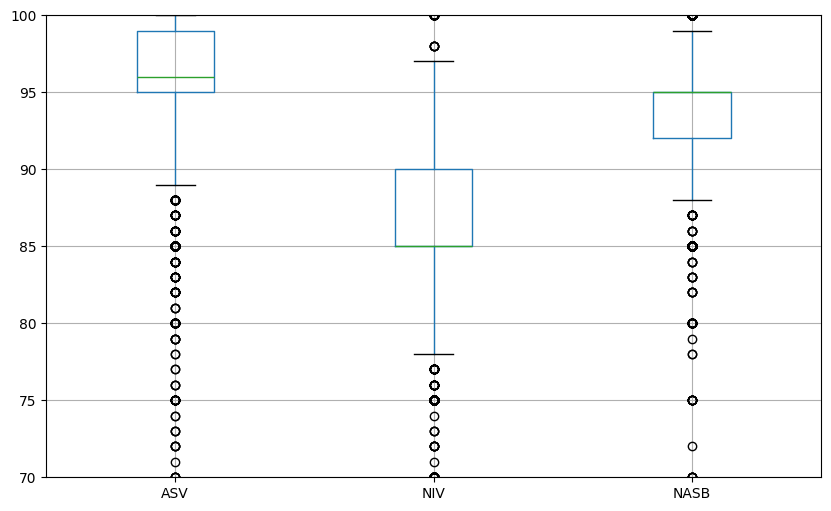

In [8]:
df = pd.read_csv(similarity_scores_path, na_filter=False)
df.columns = df.columns.str.strip()
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors='coerce')
df[df.columns[2]] = pd.to_numeric(df[df.columns[2]], errors='coerce')
df[df.columns[3]] = pd.to_numeric(df[df.columns[3]], errors='coerce')
df = df.dropna(subset=[df.columns[3]])

plt.figure(figsize=(10, 6))  # Adjust figure size if needed
boxplot = df.boxplot(column=['ASV', 'NIV', 'NASB'])
plt.ylim(70, 100)  # Set the y-axis limits from 0 to 100

## Combine and Format the Final Text

The code below will take all the generated books and combine them into a finished whole using html. This can then be converted into any major ebook format using calibre.

In [48]:
def book_to_html(book, abb, num_chapters):

  with open(f"{OASV_path}/{book}", "r") as f:
    book_text = f.read()

  # Regular expression to find chapters (assuming chapters start with "Chapter [number]")
  # Remove the first empty string resulting from the split
  all_chapters = re.split(rf"\n{book} \d+", book_text)
  if len(all_chapters) != num_chapters:
    print(f"Warning: {book} has {len(all_chapters)} chapters, but should have {num_chapters} chapters.")

  # Create the HTML content
  html_header = f'<h1 id="{book.lower().replace(" ", "-")}">{book}</h1><ul>\n'
  html_body = ""

  chapter_number = 1
  for chapter_text in all_chapters:
      chapter_title = f"{book} {chapter_number}"  # Basic chapter title
      html_header += f'<li><a href="#{chapter_title.lower().replace(" ", "-")}">{chapter_title}</a></li>\n'

      html_body += f"""<h3 id="{chapter_title.lower().replace(" ", "-")}">{chapter_title}</h3>\n"""
      verses = [verse for verse in chapter_text.strip().split("\n") if verse.startswith(f'[{abb}')]
      for verse in verses:
        html_body += f"""<p>{verse.strip()}</p>\n"""  # Add chapter text

      chapter_number += 1

  html_header += "</ul>\n"

  return html_header + html_body

In [52]:
html_header = """<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="UTF-8">\n
    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n
    <title>Bible</title>\n</head>
    <h2>Open American Standard Version (OASV)</h2>
    <h3>The OASV is an open-source update to the venerable 1901 American Standard Version (ASV).</h3>\n
    <p>The 1901 ASV is a classic, long considered to be one of the most accurate translations in the English language. It is currently in the Public Domain, which means it is free to quote, reprint, copy and use for any purpose. Unfortunately, the language of the ASV is archaic, and nearly inaccessible to the modern reader.</p>\n
    <p>The OASV is nearly identical to the ASV in every way, including word order, punctuation and capitalization. This ensures that the OASV retains the same literal fidelity to the ancient scriptures. However, the language of the OASV has been significantly updated for modern readers, bringing this classic Bible to a new generation.</p>\n
    <p>Importantly, the OASV is completely open-source. Not only is the full text is free to use, free to copy and free to print, but the entire methodology for producing the text can be duplicated by anyone: <a href="https://github.com/joshuadickey/OASV">https://github.com/joshuadickey/OASV</a>.</p>\n
    <p>I pray that you benefit from reading, sharing and building upon this modern translation of the free and open Bible,</p>\n
    <p>Dr. Joshua Thaxter Dickey</p>"""

html_header += "<h2>Old Testament</h2>\n<ul>\n"
html_body = "<body>"

for book, abb, chapters in ot_books:
  print(f"Processing {book}...")
  html_header += f'<li><a href="#{book.lower().replace(" ", "-")}">{book}</a></li>\n'

  try:
    book_html = book_to_html(book, abb, chapters)
  except:
    print(f"Error reading {book}")
  html_body += book_html

html_header += "</ul>\n<h2>New Testament</h2>\n<ul>\n"
for book, abb, chapters in nt_books:
  print(f"Processing {book}...")
  html_header += f'<li><a href="#{book.lower().replace(" ", "-")}">{book}</a></li>\n'

  try:
    book_html = book_to_html(book, abb, chapters)
  except:
    print(f"Error reading {book}")
  html_body += book_html
html_header += "</ul>\n"

html_body += "</body>\n</html>"

html_output = html_header + html_body

# Save the HTML to a file
text_path = f"{OASV_path}/OASV.html"
with open(text_path, "w") as f:
    f.write(html_output)

print(f"Saved the full text to {text_path}...")

Processing Genesis...
Processing Exodus...
Processing Leviticus...
Processing Numbers...
Processing Deuteronomy...
Processing Joshua...
Processing Judges...
Processing Ruth...
Processing 1 Samuel...
Processing 2 Samuel...
Processing 1 Kings...
Processing 2 Kings...
Processing 1 Chronicles...
Processing 2 Chronicles...
Processing Ezra...
Processing Nehemiah...
Processing Esther...
Processing Job...
Processing Psalms...
Processing Proverbs...
Processing Ecclesiastes...
Processing Song of Solomon...
Processing Isaiah...
Processing Jeremiah...
Processing Lamentations...
Processing Ezekiel...
Processing Daniel...
Processing Hosea...
Processing Joel...
Processing Amos...
Processing Obadiah...
Processing Jonah...
Processing Micah...
Processing Nahum...
Processing Habakkuk...
Processing Zephaniah...
Processing Haggai...
Processing Zechariah...
Processing Malachi...
Processing Matthew...
Processing Mark...
Processing Luke...
Processing John...
Processing Acts...
Processing Romans...
Processing 

In [53]:
# Define paths
html_path = f"{OASV_path}/OASV.html"  # Replace with your HTML file path
cover_path = f"{OASV_path}/cover.png"  # Replace with your cover image path (optional)
output_path = f"{OASV_path}/OASV.epub"

# Convert HTML to EPUB using Calibre's ebook-convert
!ebook-convert "{html_path}" "{output_path}" \
  --output-profile=kindle \
  --max-toc-links=66 \
  --cover="{cover_path}"  # Add this line if you have a cover image


# Download the generated EPUB file (optional)
files.download(output_path)


Conversion options changed from defaults:
  cover: '/content/drive/My Drive/OASV_JHV/cover.png'
  output_profile: 'kindle'
  max_toc_links: 66.0
1% Converting input to HTML...
InputFormatPlugin: HTML Input running
on /content/drive/My Drive/OASV_JHV/OASV.html
Language not specified
Creator not specified
Building file list...
Normalizing filename cases
Rewriting HTML links
34% Running transforms on e-book...
Merging user specified metadata...
Detecting structure...
Maximum TOC links reached, stopping.
Auto generated TOC with 66 entries.
Flattening CSS and remapping font sizes...
Source base font size is 12.00000pt
Removing fake margins...
Cleaning up manifest...
Trimming unused files from manifest...
Creating EPUB Output...
67% Running EPUB Output plugin
Rescaling image from 2246x3067 to 451x616 cover.png
Splitting markup on page breaks and flow limits, if any...
	Looking for large trees in OASV.html...
	Found large tree #21
	Found large tree #26
	Split into 71 parts
EPUB output written

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# keep rows with quality values of 0
df = df[df[df.columns[1]] == 0]
df = df.sort_values(by=df.columns[0])
df

In [ ]:
book = "Psalms"
abb = "PSA"
num_ch = 150

print(f"Processing {book}...")
gen_OASV_Book(book, abb, num_ch, 117)

combine_chapters("Psalms")